In [1]:
%run ../../macro_tQ.py
import sys
sys.path.append('../../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.tools.visualization import array_to_latex

In [2]:
'angulos de medida'
phi_divs = 100
phi_list=np.linspace(0,2*np.pi,phi_divs) #lista de angulos'

'lista de correlaciones C[i] a calcular'
C=[0,0,0,0]

'lista de valores de R'
R=np.zeros(phi_divs)

'Numero de medidas'
nshots = 2048

from qiskit import QuantumCircuit, Aer, execute
M_simulator = Aer.get_backend('qasm_simulator')



/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


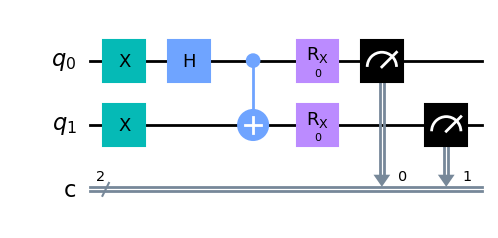

In [3]:
for j in range(phi_divs): 

    'ángulos de medida'
    phi=phi_list[j] 
    '''A' = 2\phi, A = B = phi, B' = 0'''
    angles_AB=[[phi,phi],[2*phi,phi],[phi,0],[2*phi,0]] # AB , A'B , AB', A'B'

    for i in range(4):        
        'una pareja de ángulos uno para A y otro para B '
        ang_AB=angles_AB[i]

        'hay un circuito para cada proceso de medida'
        qc=QuantumCircuit(2,2)
        'creamos el par de Bell B(11)'
        qc.x(0)
        qc.x(1)
        qc.h(0)
        qc.cx(0,1)

         
        'simulamos la medida en la base de los polarizadores de A y B rotados en torno al eje x'
        qc.rx(-ang_AB[0],0)  # notar el valor negativo del ángulo de rotación 
        qc.rx(-ang_AB[1],1)
        qc.measure([0,1],[0,1])
        
        if j ==0 and i ==0:
            display(qc.draw('mpl'))
        ' medimos '
        counts=execute(qc,backend = M_simulator,shots = nshots).result().get_counts()         
        'construimos el correlador'
        C[i]= 0 
        for bitstring, counts in counts.items():
            C[i] += (-1)**(sum([int(bit) for bit in bitstring])) * counts/nshots 

    'construimos la cantidad R'
    R[j]=np.abs(C[0]+C[1]+C[2]-C[3])

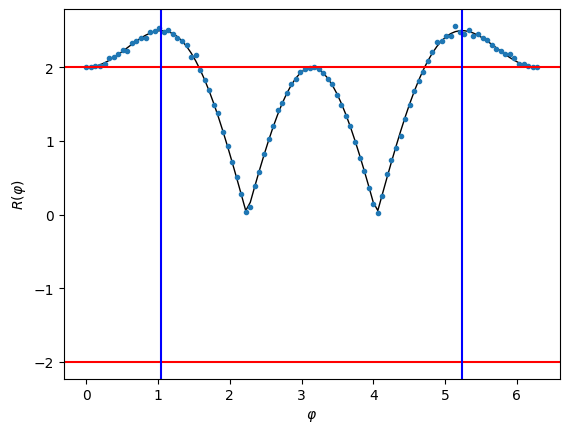

In [4]:
' función analítica '
fx= np.abs(1 + 2*np.cos(phi_list) - np.cos(2*phi_list))
plt.plot(phi_list,fx,'k-',linewidth=1)

' resultado de la simulación'
plt.plot(phi_list,R,'.')
plt.axhline(y = 2, color = 'r', linestyle = '-')
plt.axhline(y = -2, color = 'r', linestyle = '-')

' líneas horizotales en +2 y - 2'
plt.axvline(x = np.pi/3, color = 'b', linestyle = '-')
plt.axvline(x = 5*np.pi/3, color = 'b', linestyle = '-')
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$R(\varphi)$')
plt.show()

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


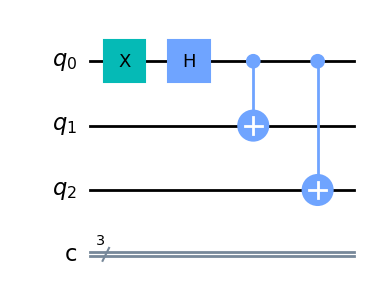

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute

qc_GHZ = QuantumCircuit(3,3) 

qc_GHZ.x(0)
qc_GHZ.h(0)
qc_GHZ.cx(0,1)
qc_GHZ.cx(0,2)

qc_GHZ.draw(output='mpl')

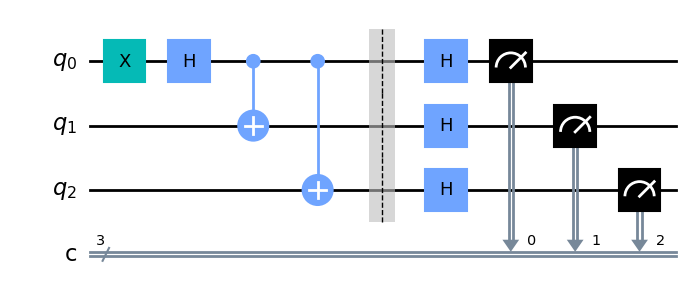

In [6]:
from qiskit import Aer, execute

M_backend = Aer.get_backend('qasm_simulator')
shots=1000


'elige uno de los términos siguientes'
#multibasis = 'YYX'
#multibasis = 'YXY'
#multibasis = 'XYY'
multibasis = 'XXX'

qc_GHZ.barrier()
tQ.add_multimeasure_XYZ(qc_GHZ, multibasis)
qc_GHZ.draw(output='mpl')

In [7]:
cuentas_GHZ = execute(qc_GHZ,M_backend,shots=shots).result().get_counts()
print('<'+str(multibasis)+'> =', tQ.expval_Zn_from_counts(cuentas_GHZ)[0])

<XXX> = -1.0


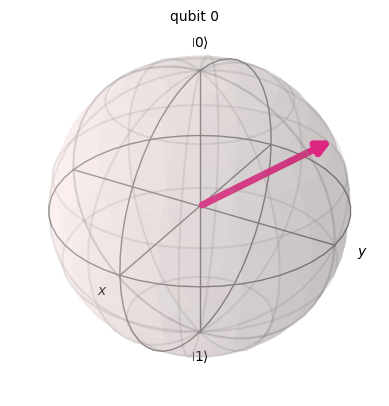

In [8]:
# escoge dos ángulos theta y phi en la esfera de Bloch
[theta,phi]=[1.1 , 2.2]

# o hazlo de forma aleatoria
#import random
#[theta,phi] = np.array([np.pi*np.random.rand(),2*np.pi*np.random.rand()])

estado = [np.cos(theta/2),(np.exp(1j*phi))*np.sin(theta/2)]

#visualicémoslo en la esfera de Bloch
from qiskit.visualization import plot_bloch_multivector, array_to_latex  
plot_bloch_multivector(estado)

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

qrA = QuantumRegister(2, name="qAlice") 
qrB =  QuantumRegister(1, name="qBob") 
crx = ClassicalRegister(1, name="crx") 
cry = ClassicalRegister(1, name="cry") 

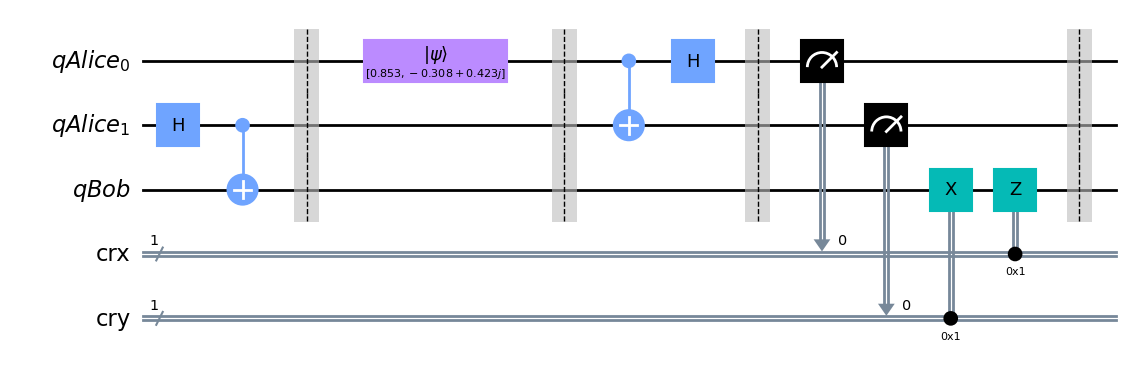

In [10]:
# inicializa el circuito
qc = QuantumCircuit(qrA,qrB, crx, cry)

# Alice y Bob comparten un par de Bell
qc.h(qrA[1])
qc.cx(qrA[1],qrB[0])
qc.barrier()

# inyecta en el circuito el estado a teleportar
qc.initialize(estado,0)

qc.barrier()

# Añade un medidor de estados de Bell en los cúbits de Alice y efectúa las medidas
qc.cx(qrA[0],qrA[1])
qc.h(qrA[0])
qc.barrier()
qc.measure([qrA[0],qrA[1]],[0,1])

# Añade el operador X^y Z^x controlado clásicamente por las salidas x e y 
qc.x(qrB[0]).c_if(cry, 1)  
qc.z(qrB[0]).c_if(crx, 1)  
qc.barrier()

#visualiza el circuito 
qc.draw('mpl')

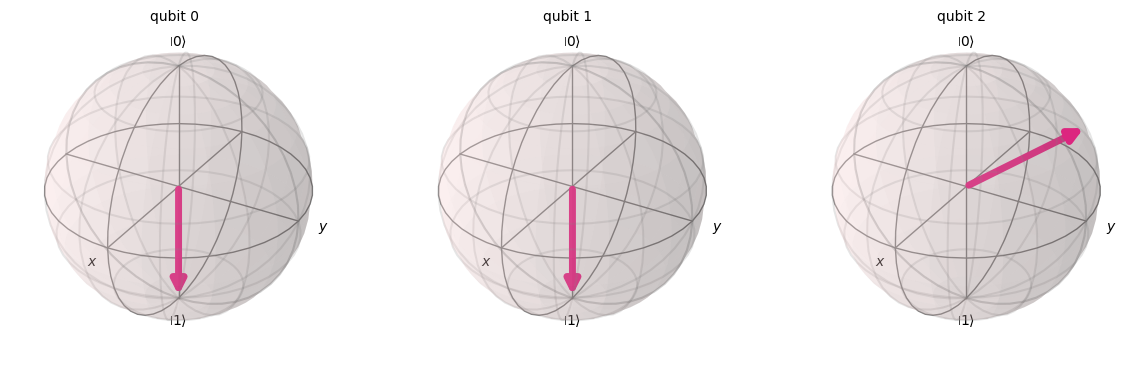

In [11]:
# ejecuta varias veces y observa el resultado 
S_simulator = Aer.get_backend('statevector_simulator')
out_vector=execute(qc,S_simulator).result().get_statevector()
plot_bloch_multivector(out_vector)